# 11wk-2: 순환신경망 (1) – 임베딩 공간(Embedding Space)의 이해

최규빈  
2024-05-15

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/11wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yrZ4HbNgYDmklcumxJHSOp&si=XO2ZBUtY_m1mSFvX>

# 2. Imports

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
soft = torch.nn.Softmax(dim=1)
ohot = torch.nn.functional.one_hot

# 3. `abc`

## A. Data

In [121]:
txt = list('abc'*100)
txt[:10]

In [122]:
df_train = pd.DataFrame({'x': txt[:-1], 'y': txt[1:]})
df_train[:5]

In [123]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2}))

## B. MLP – 하나의 은닉노드

In [124]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=1),
    torch.nn.Tanh(), # 이거를 씁니다. 왜 이걸 쓰는지 설명하면 너무 길어요. 외우세여. 
    torch.nn.Linear(in_features=1, out_features=3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [125]:
for epoc in range(50):
    ## 1 
    netout = net(x) 
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [126]:
yhat = soft(netout)
yhat.argmax(axis=1),y

## C. 적합결과의 해석 ($\star$)

`-` 네트워크 분해

In [127]:
ebdd, tanh, linr = net 

`-` ebdd 레이어 통과직후

In [128]:
ebdd_x = ebdd(x).data[:9]
ebdd_x

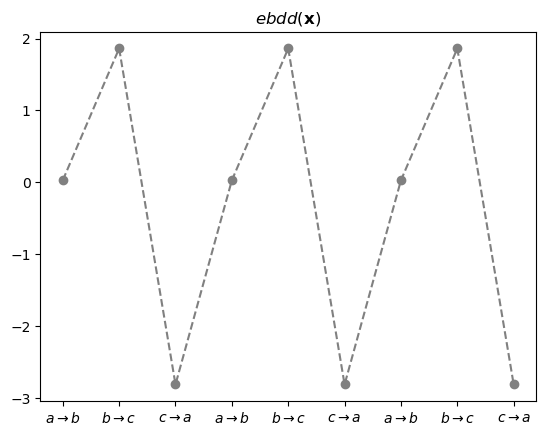

In [129]:
plt.plot(ebdd_x, '--o', color='gray')
plt.title(r"$ebdd({\bf x})$")
plt.title(r"$ebdd({\bf x})$")
plt.xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3);

`-` (ebdd -\> tanh) 레이어 통과직후

In [130]:
ebdd_x = ebdd(x).data[:9]
h = tanh(ebdd(x)).data[:9]
torch.concat([ebdd_x,h],axis=1)

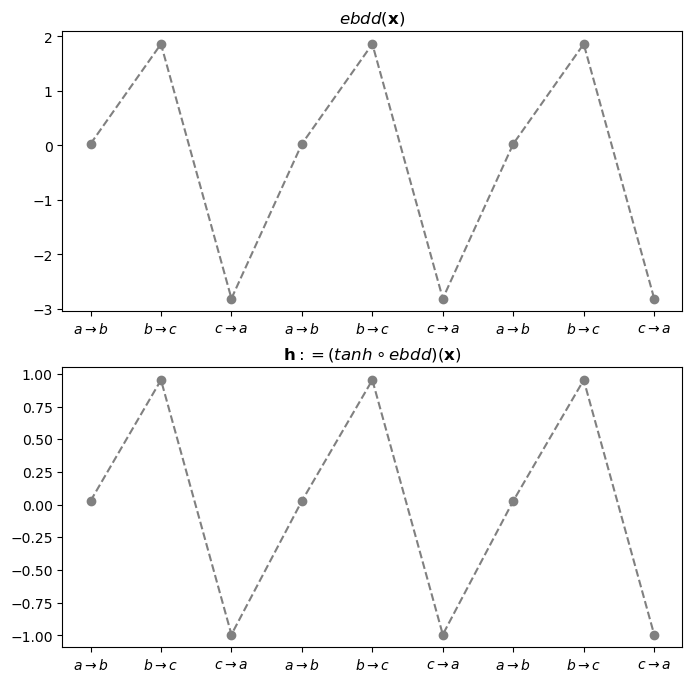

In [131]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(ebdd_x, '--o', color='gray')
ax[0].set_title(r"$ebdd({\bf x})$")
ax[0].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[1].plot(h, '--o', color='gray')
ax[1].set_title(r"${\bf h}:=(tanh \circ ebdd)({\bf x})$")
ax[1].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3);

-   여기까지 2개는 세트로 봐도 무방할듯
-   결과를 ${\boldsymbol h}$로 생각하자.

`-` (임베딩 -\> tanh -\> linr) 통과직후 – 여기에서 차원이 3차원으로
된다.

In [132]:
ebdd_x = ebdd(x).data[:9]
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
#netout = net(x).data[:9]
torch.concat([ebdd_x,h,netout],axis=1)

In [133]:
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]

In [134]:
linr.weight, linr.bias

In [139]:
netout_a, h*(-3.8416) + (-1.2536)

-   값이 살짝 다른이유는 Appendix 참고
-   여기서는 그냥 “똑같은 결과가 나왔다” 라고 생각하고 넘어가자

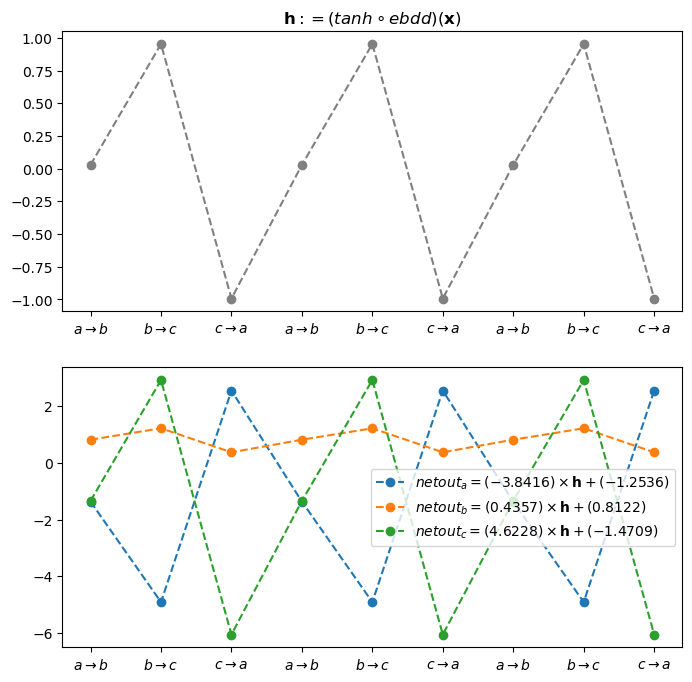

In [19]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(h, '--o', color='gray')
ax[0].set_title(r"${\bf h}:=(tanh \circ ebdd)({\bf x})$")
ax[0].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3);
ax[1].plot(netout_a, '--o', label=r"$netout_a =  (-3.8416)\times {\bf h} + (-1.2536)$")
ax[1].plot(netout_b, '--o', label=r"$netout_b =  ( 0.4357)\times {\bf h} + (0.8122)$")
ax[1].plot(netout_c, '--o', label=r"$netout_c =  (4.6228)\times {\bf h} + (-1.4709)$")
ax[1].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3);
ax[1].legend()

-   파란색: 의사표현 확실
-   초록색: 의사표현 확실
-   주황색: 약간 회색분자느낌, 사실상 얘가 결정하는건 없음.

`-` 이 네트워크는 `b->c` 인 맵핑과 `c->a`인 맵핑은 확실히 학습한듯
보이지만 `a->b`인 맵핑은 그다지 잘 학습한 느낌이 들지 않는다.

-   마치 `y=b`를 맞추는 방식은 `y=c` 도 아닌것 같고 `y=a` 도 아닌것
    같으니까 `y=b` 아닐까?” 같은 느낌

`-` 전체과정 시각화

In [20]:
onehot_x = ohot(x).data[:9]
onehot_a = onehot_x[:,[0]]
onehot_b = onehot_x[:,[1]]
onehot_c = onehot_x[:,[2]]
#--#
ebdd_x = ebdd(x).data[:9]
#--#
h = tanh(ebdd(x)).data[:9]
#--#
netout = linr(tanh(ebdd(x))).data[:9]
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]
#--#
yhat = soft(net(x)).data[:9]
yhat_a = yhat[:,[0]]
yhat_b = yhat[:,[1]]
yhat_c = yhat[:,[2]]
#--#
torch.concat([ebdd_x,h,netout,yhat],axis=1).numpy().round(2)

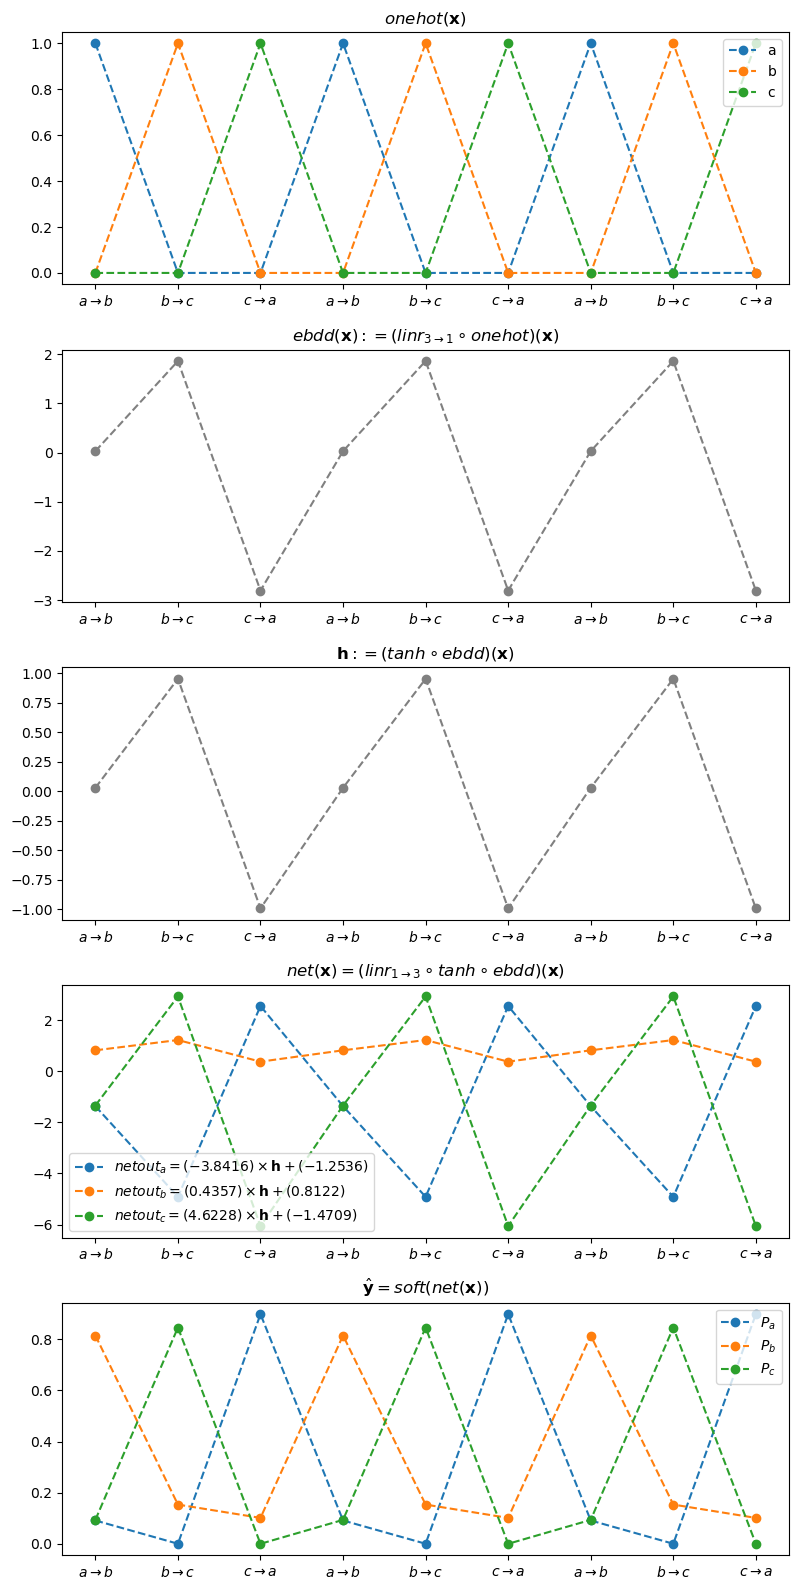

In [21]:
fig, ax = plt.subplots(5,1,figsize=(8,16))
ax[0].set_title(r"$onehot({\bf x})$")
ax[0].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[0].plot(onehot_a,'--o',label="a")
ax[0].plot(onehot_b,'--o',label="b")
ax[0].plot(onehot_c,'--o',label="c")
ax[0].legend()
#--#
ax[1].set_title(r"$ebdd({\bf x}):=(linr_{3 \to 1} \circ onehot)({\bf x})$")
ax[1].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[1].plot(ebdd_x, '--o', color='gray')
#--#
ax[2].set_title(r"${\bf h}:=(tanh \circ ebdd)({\bf x})$")
ax[2].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[2].plot(h, '--o', color='gray')
#--#
ax[3].set_title(r"$net({\bf x})=(linr_{1 \to 3} \circ tanh \circ ebdd)({\bf x})$")
ax[3].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[3].plot(netout_a,'--o',label=r"$netout_a =  (-3.8416)\times {\bf h} + (-1.2536)$")
ax[3].plot(netout_b,'--o',label=r"$netout_b =  ( 0.4357)\times {\bf h} + (0.8122)$")
ax[3].plot(netout_c,'--o',label=r"$netout_c =  (4.6228)\times {\bf h} + (-1.4709)$")
ax[3].legend()
#--#
ax[4].set_title(r"$\hat{\bf y} = soft(net({\bf x}))$")
ax[4].set_xticks(range(9),[r'$a\to b$', r'$b\to c$', r'$c\to a$']*3)
ax[4].plot(yhat_a,'--o',label=r"$P_a$")
ax[4].plot(yhat_b,'--o',label=r"$P_b$")
ax[4].plot(yhat_c,'--o',label=r"$P_c$")
ax[4].legend()
plt.tight_layout()

`-` 다른방식의 시각화

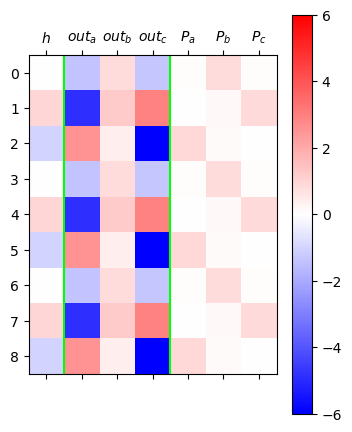

In [22]:
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,netout,yhat],axis=1)
#---#
plt.matshow(mat,cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(0.5,color="lime")
plt.axvline(3.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=[r"$h$",r"$out_a$",r"$out_b$",r"$out_c$",r"$P_a$",r"$P_b$",r"$P_c$"]);

-   netout 을 보는 요령: 가장 빨간부분이 예측값이 된다.
-   역시 $out_b$의 경우 애매한 색깔만 있음. (가장 빨갛다기 보다 다른게
    파란색이 나와줘서 정답을 맞추는 느낌)
-   그런데 $out_b$의 경우에 대응하는 ${\boldsymbol h}$를 살펴보니
    흰색임. 이것은 값이 0이라는 의미인데 이때는 ${\boldsymbol h}$ 에
    걸리는 선형변환 $linr_{1 \to 3}$ 의 weight 가 의미없고 bias만
    의미있기 때문에 특징을 잡기에 불리하다.
-   따라서 ${\boldsymbol h}$가 확실한 색을 가지고 있는것이 유리함.
    그렇지만 확실한 색인 빨강 파랑은 이미 차지된 상태라서 어쩔수 없이
    0이 선택된 것..

## D. MLP – 두개의 은닉노드

`-` 적합

In [23]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=3),
    #torch.nn.Softmax(),
)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [24]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

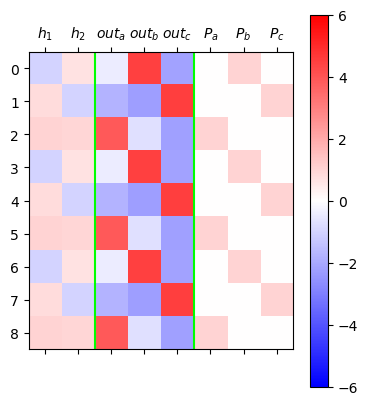

In [25]:
ebdd,tanh,linr = net
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,netout,yhat],axis=1)
#---#
plt.matshow(mat,cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(1.5,color="lime")
plt.axvline(4.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7],labels=[r"$h_1$",r"$h_2$",r"$out_a$",r"$out_b$",r"$out_c$",r"$P_a$",r"$P_b$",r"$P_c$"]);

`-` 시각화결과해석: 깔끔함. netout의 가장 빨간부분도 너무 명확함.
${\boldsymbol h}$가 0이 아닌 값으로 학습되어있음

-   x=a $\Rightarrow$ h=(파,빨) $\Rightarrow$ y=b
-   x=b $\Rightarrow$ h=(빨,파) $\Rightarrow$ y=c
-   x=c $\Rightarrow$ h=(빨,빨) $\Rightarrow$ y=a
-   h = (파,파) 는 사용하지 않음. –\> 문자열 d를 하나 더 쓸수 있는
    공간이 $h$에 있다고 해석할 수 있음..

# 4. `abcd`

## A. Data

In [44]:
txt = list('abcd'*100)
txt[:10]

In [45]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [46]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2, 'd':3}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2, 'd':3}))

## B. MLP – 하나의 은닉노드

`-` 학습

In [51]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=4)
)
ebdd,tanh,linr = net 
ebdd.weight.data = torch.tensor([[-0.3333],[-2.5000],[5.0000],[0.3333]])
linr.weight.data = torch.tensor([[1.5000],[-6.0000],[-2.0000],[6.0000]])
linr.bias.data = torch.tensor([0.1500, -2.0000,  0.1500, -2.000])
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [52]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [64]:
onehot_x = ohot(x).data[:8]
onehot_a = onehot_x[:,[0]]
onehot_b = onehot_x[:,[1]]
onehot_c = onehot_x[:,[2]]
onehot_d = onehot_x[:,[3]]
#--#
ebdd_x = ebdd(x).data[:8]
#--#
h = tanh(ebdd(x)).data[:8]
#--#
netout = linr(tanh(ebdd(x))).data[:8]
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]
netout_d = netout[:,[3]]
#--#
yhat = soft(net(x)).data[:8]
yhat_a = yhat[:,[0]]
yhat_b = yhat[:,[1]]
yhat_c = yhat[:,[2]]
yhat_d = yhat[:,[3]]
#--#

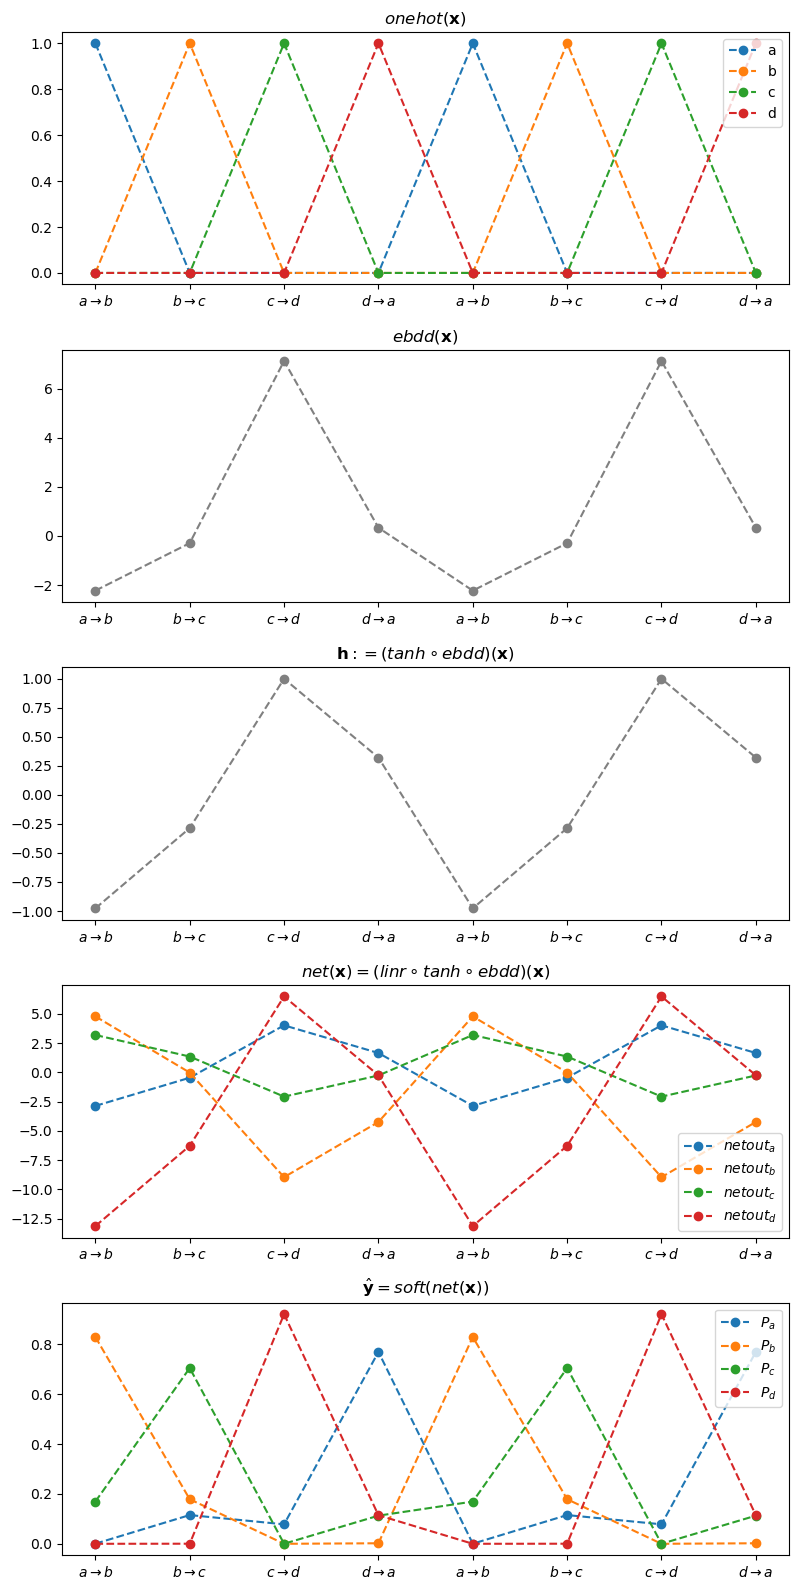

In [65]:
fig, ax = plt.subplots(5,1,figsize=(8,16))
ax[0].set_title(r"$onehot({\bf x})$")
ax[0].set_xticks(range(8),[r'$a\to b$', r'$b\to c$', r'$c\to d$', r'$d\to a$']*2)
ax[0].plot(onehot_a,'--o',label="a")
ax[0].plot(onehot_b,'--o',label="b")
ax[0].plot(onehot_c,'--o',label="c")
ax[0].plot(onehot_d,'--o',label="d")
ax[0].legend()
#--#
ax[1].set_title(r"$ebdd({\bf x})$")
ax[1].set_xticks(range(8),[r'$a\to b$', r'$b\to c$', r'$c\to d$', r'$d\to a$']*2)
ax[1].plot(ebdd_x, '--o', color='gray')
#--#
ax[2].set_title(r"${\bf h}:=(tanh \circ ebdd)({\bf x})$")
ax[2].set_xticks(range(8),[r'$a\to b$', r'$b\to c$', r'$c\to d$', r'$d\to a$']*2)
ax[2].plot(h, '--o', color='gray')
#--#
ax[3].set_title(r"$net({\bf x})=(linr \circ tanh \circ ebdd)({\bf x})$")
ax[3].set_xticks(range(8),[r'$a\to b$', r'$b\to c$', r'$c\to d$', r'$d\to a$']*2)
ax[3].plot(netout_a,'--o',label=r"$netout_a$")
ax[3].plot(netout_b,'--o',label=r"$netout_b$")
ax[3].plot(netout_c,'--o',label=r"$netout_c$")
ax[3].plot(netout_d,'--o',label=r"$netout_d$")
ax[3].legend()
#--#
ax[4].set_title(r"$\hat{\bf y} = soft(net({\bf x}))$")
ax[4].set_xticks(range(8),[r'$a\to b$', r'$b\to c$', r'$c\to d$', r'$d\to a$']*2)
ax[4].plot(yhat_a,'--o',label=r"$P_a$")
ax[4].plot(yhat_b,'--o',label=r"$P_b$")
ax[4].plot(yhat_c,'--o',label=r"$P_c$")
ax[4].plot(yhat_d,'--o',label=r"$P_d$")
ax[4].legend()
plt.tight_layout()

`-` 결과시각화2

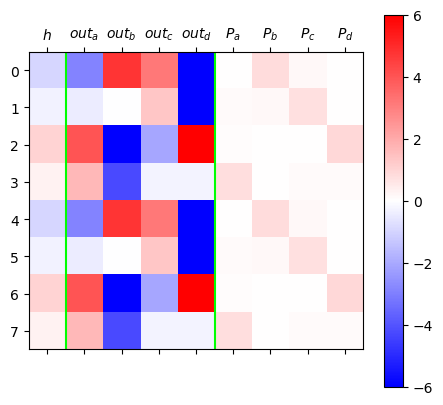

In [68]:
ebdd,tanh,linr = net
h = tanh(ebdd(x)).data[:8]
netout = linr(tanh(ebdd(x))).data[:8]
yhat = soft(net(x)).data[:8]
mat = torch.concat([h,netout,yhat],axis=1)
#---#
plt.matshow(mat,cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(0.5,color="lime")
plt.axvline(4.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8],labels=[r"$h$",r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",r"$P_a$",r"$P_b$",r"$P_c$",r"$P_d$"]);

-   out에서 제일 빨간색.. -\> 찾기 어렵죠??

## C. MLP – 두개의 은닉노드

`-` 학습

In [69]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [70]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

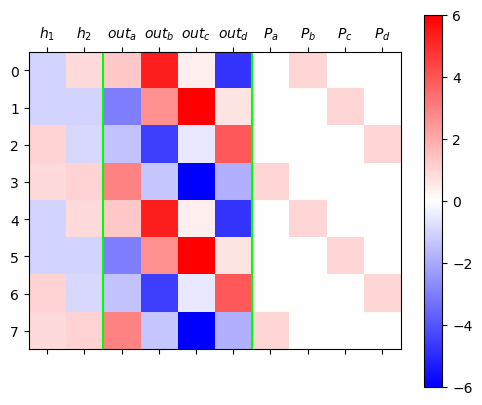

In [73]:
ebdd,tanh,linr = net
h = tanh(ebdd(x)).data[:8]
netout = linr(tanh(ebdd(x))).data[:8]
yhat = soft(net(x)).data[:8]
mat = torch.concat([h,netout,yhat],axis=1)
#---#
plt.matshow(mat,cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(1.5,color="lime")
plt.axvline(5.5,color="lime")
plt.xticks(ticks=range(10),labels=[r"$h_1$",r"$h_2$",r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",r"$P_a$",r"$P_b$",r"$P_c$",r"$P_d$"]);

## D. 비교실험

In [92]:
class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,1)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(1,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

In [113]:
class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,2)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(2,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

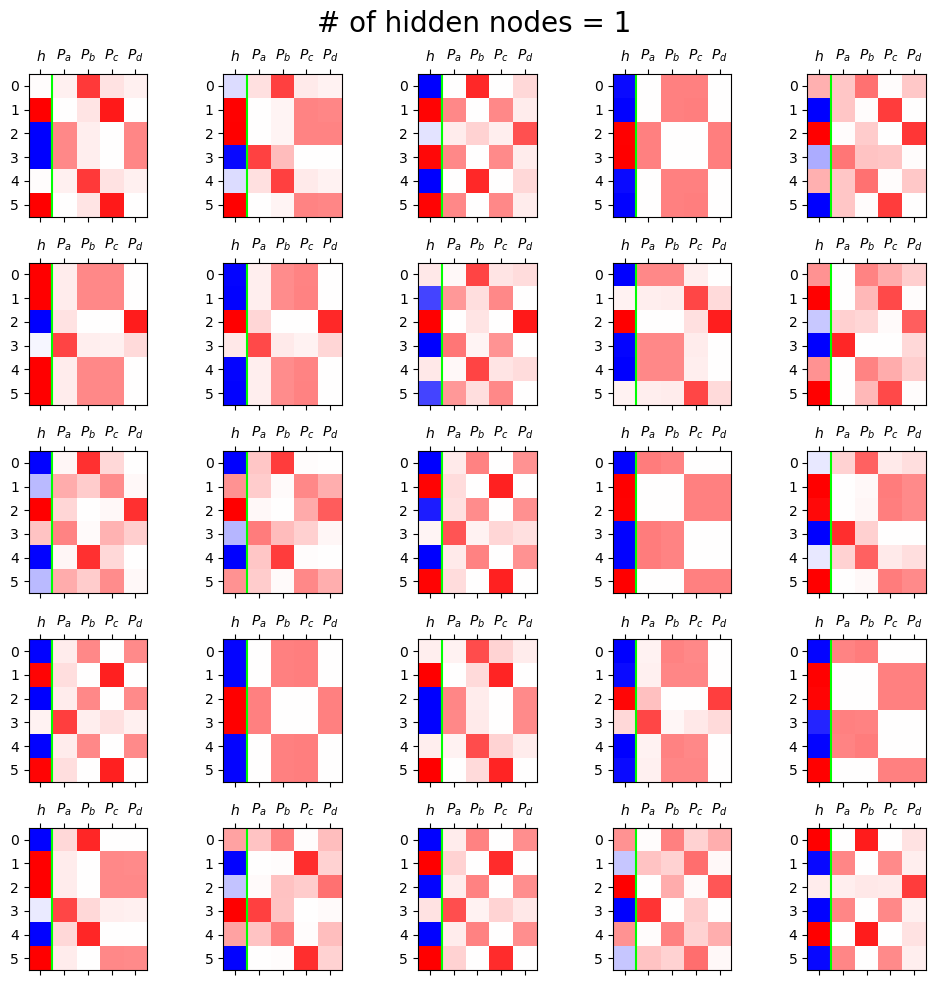

In [118]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net1()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data[:6]
        yhat = soft(net(x)).data[:6]
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat,cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(0.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4],labels=[r"$h$",r"$P_a$",r"$P_b$",r"$P_c$",r"$P_d$"])
fig.suptitle("# of hidden nodes = 1", size=20)
fig.tight_layout()

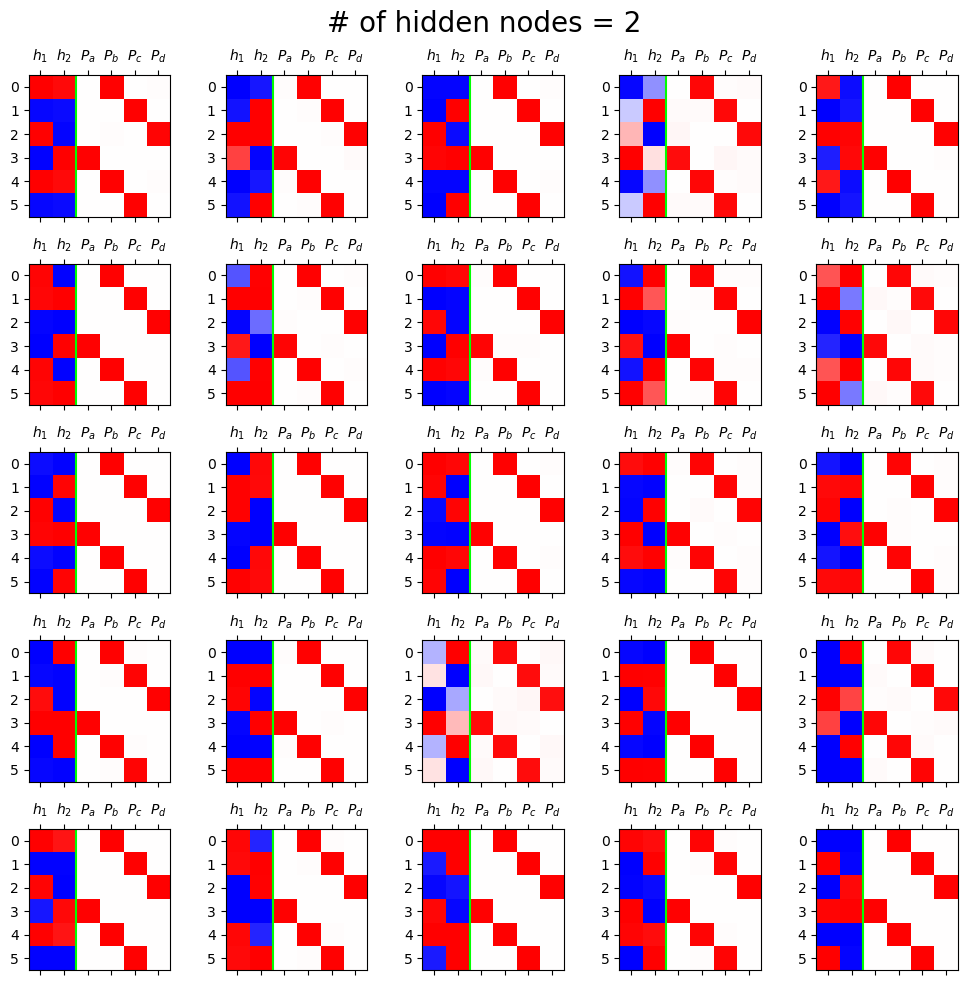

In [119]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net2()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data[:6]
        yhat = soft(net(x)).data[:6]
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat,cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(1.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4,5],labels=[r"$h_1$",r"$h_2$",r"$P_a$",r"$P_b$",r"$P_c$",r"$P_d$"])
fig.suptitle("# of hidden nodes = 2", size=20)
fig.tight_layout()        

# 5. ${\boldsymbol h}$ 에 대하여 $(\star\star\star$)

`-` ${\boldsymbol h}$는 사실 문자열 “abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

# A1. 파이토치의 정밀도

In [140]:
a = torch.tensor(3.84157)
a

In [141]:
b = torch.tensor(3.8416)
b

In [142]:
a,b # a와 b는 같아보이지만 다르다.

In [144]:
a - 0.00003 

In [145]:
b - 0.00003